In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer, ModeClusterer_HDBSCAN  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import get_mpe_data
from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [8]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'
data_path = "../../data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
weather_data_path = "../../data/nw2/mvbc_data.parquet"

turbine_data = pd.read_parquet(data_path)
weather_station_data_LAT = pd.read_parquet(weather_data_path)
#rated_data = get_rated_data(data)
#parked_data = get_parked_data(data)

In [9]:
name_location = 'NW2_D01'
mpe_data = {}
directions = ['SS', 'FA']
for direction in directions:
    mpe_data[direction] = get_mpe_data(turbine_data, direction, name_location)

In [10]:
mc = {}
clustering_data = {}
clustered_modes = {}
modes = {}

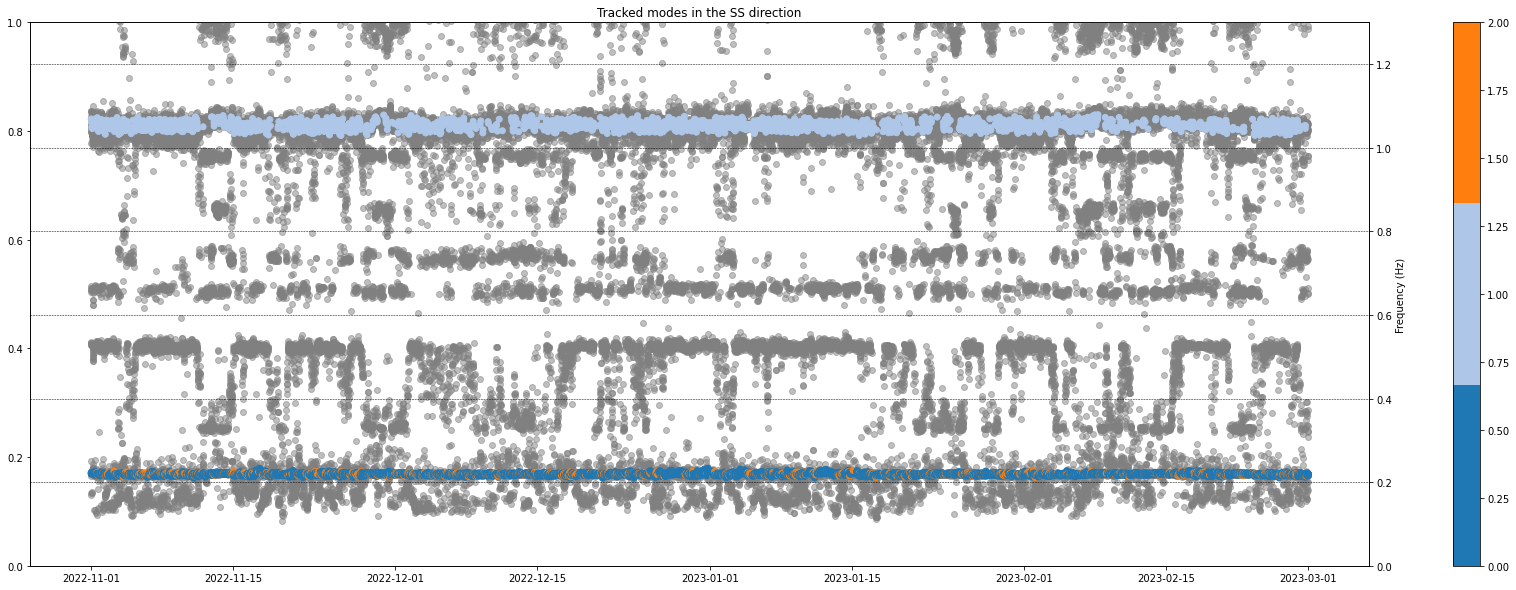

In [15]:
direction = 'SS'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 5, "damping": 10},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)

plt.show()

SS1 = clustered_modes[direction][clustered_modes[direction].labels == 1]
SS1 = SS1[~SS1.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
SS2 = clustered_modes[direction][clustered_modes[direction].labels == 0]
SS2 = SS2[~SS2.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

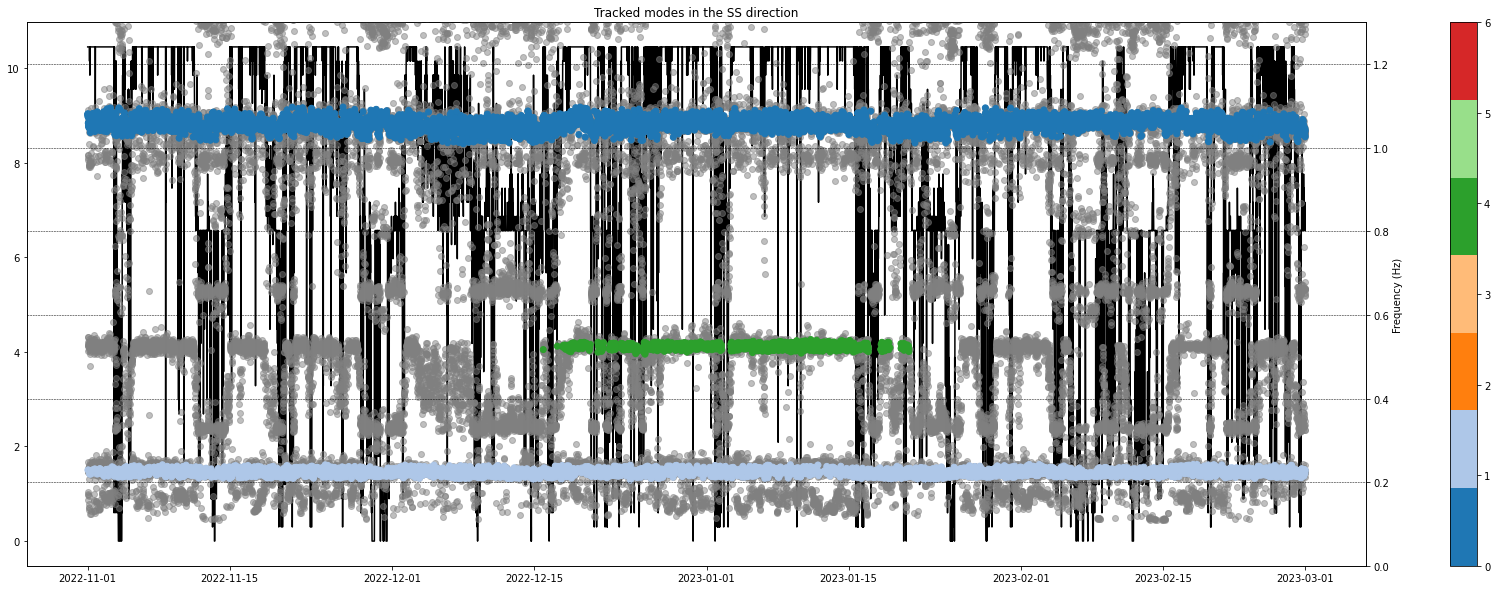

In [12]:
direction = 'FA'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 1},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)
plt.show()

FA1 = clustered_modes[direction][clustered_modes[direction].labels == 1]
FA1 = FA1[~FA1.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
FA2 = clustered_modes[direction][clustered_modes[direction].labels == 0]
FA2 = FA2[~FA2.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

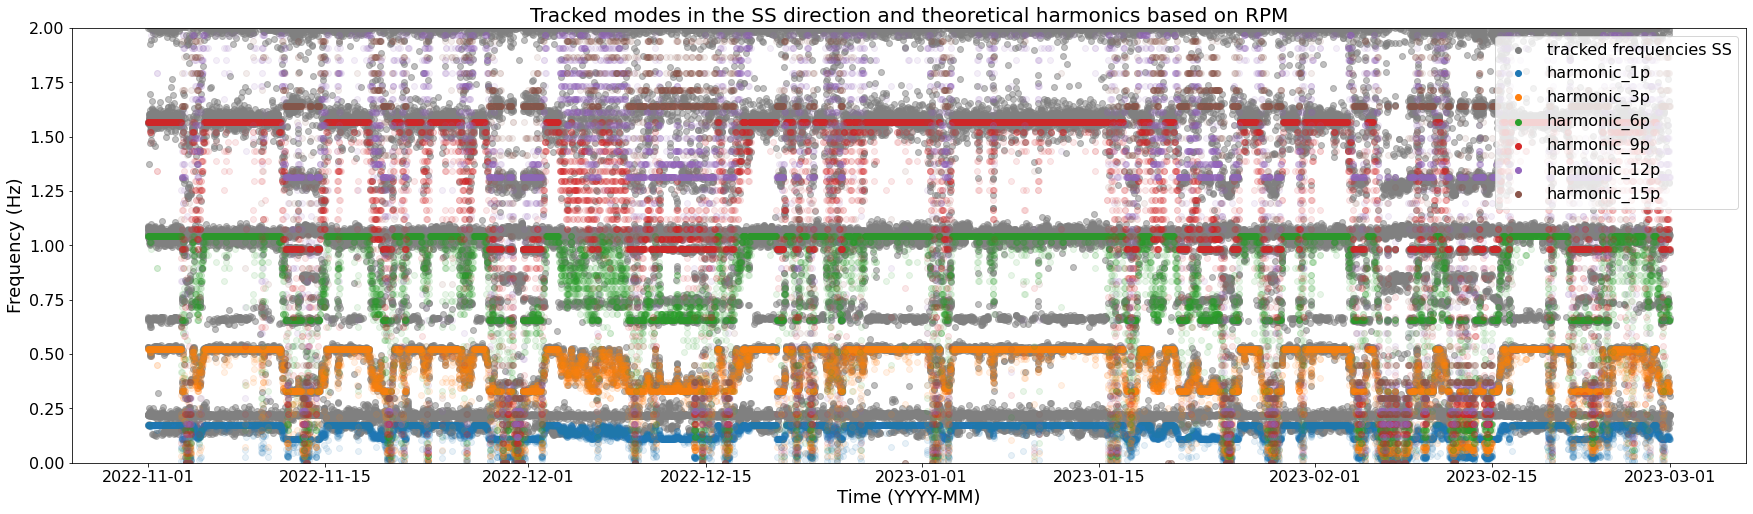

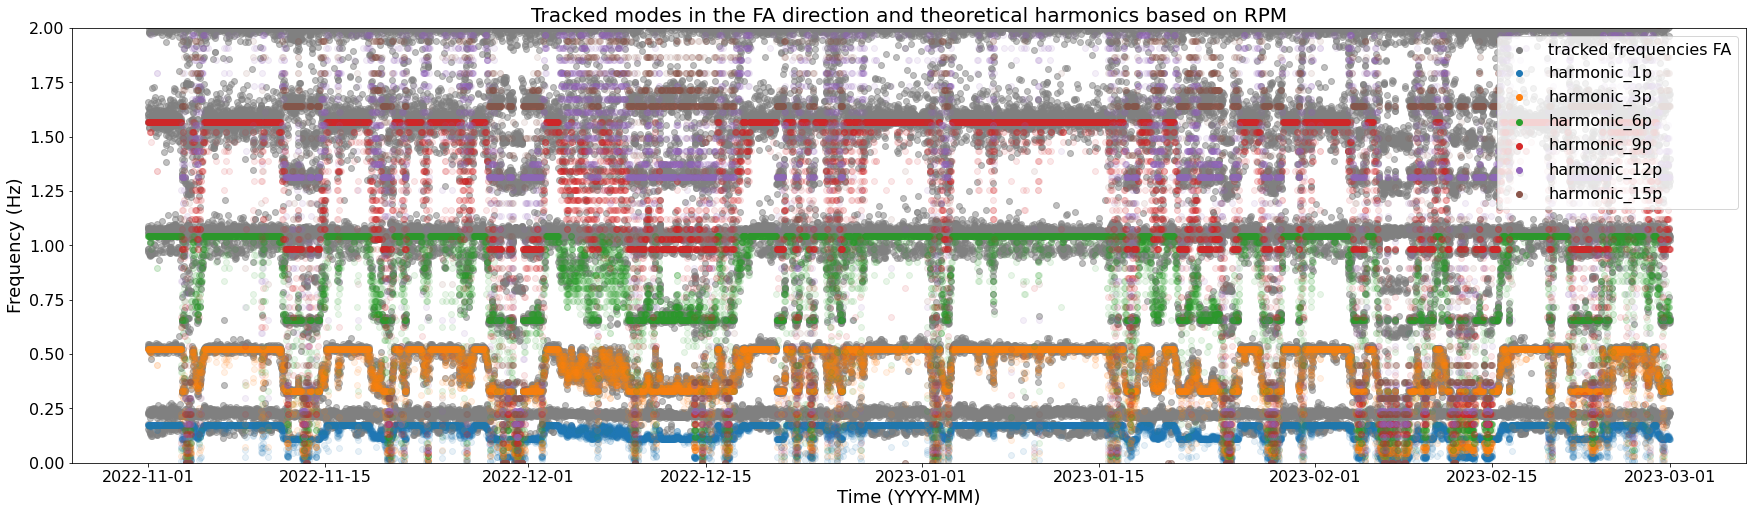

In [17]:
from oma_tracking.modal_tracking.harmonics import theoretical_harmonic
theoretical_harmonics = theoretical_harmonic(turbine_data, p_orders=[1,3,6,9,12,15])

for direction in ['SS', 'FA']:
    plt.figure(figsize = (30,8))
    plt.scatter(clustering_data[direction].index, clustering_data[direction].frequency, c='grey', alpha=0.5, label = 'tracked frequencies ' + direction)
    for col in theoretical_harmonics.columns:
        plt.scatter(theoretical_harmonics[col].index, theoretical_harmonics[col].values, alpha=0.1, label=col)
    plt.ylim(0, 2)
    plt.title('Tracked modes in the ' + direction + ' direction and theoretical harmonics based on RPM', fontsize=20)
    plt.xlabel('Time (YYYY-MM)', fontsize=18)
    plt.ylabel('Frequency (Hz)', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    legend = plt.legend(loc='upper right', fontsize=16)
    for handle in legend.legendHandles:
        handle.set_alpha(1.0)
    plt.show()

SS


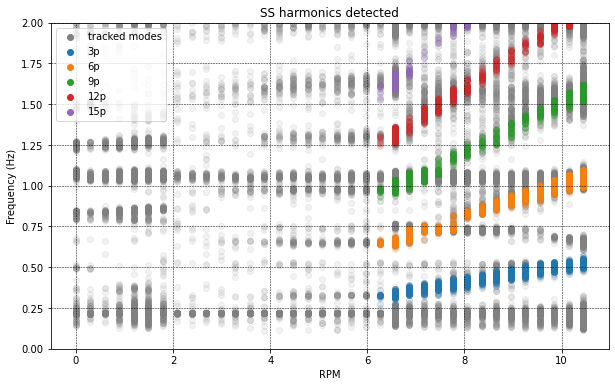

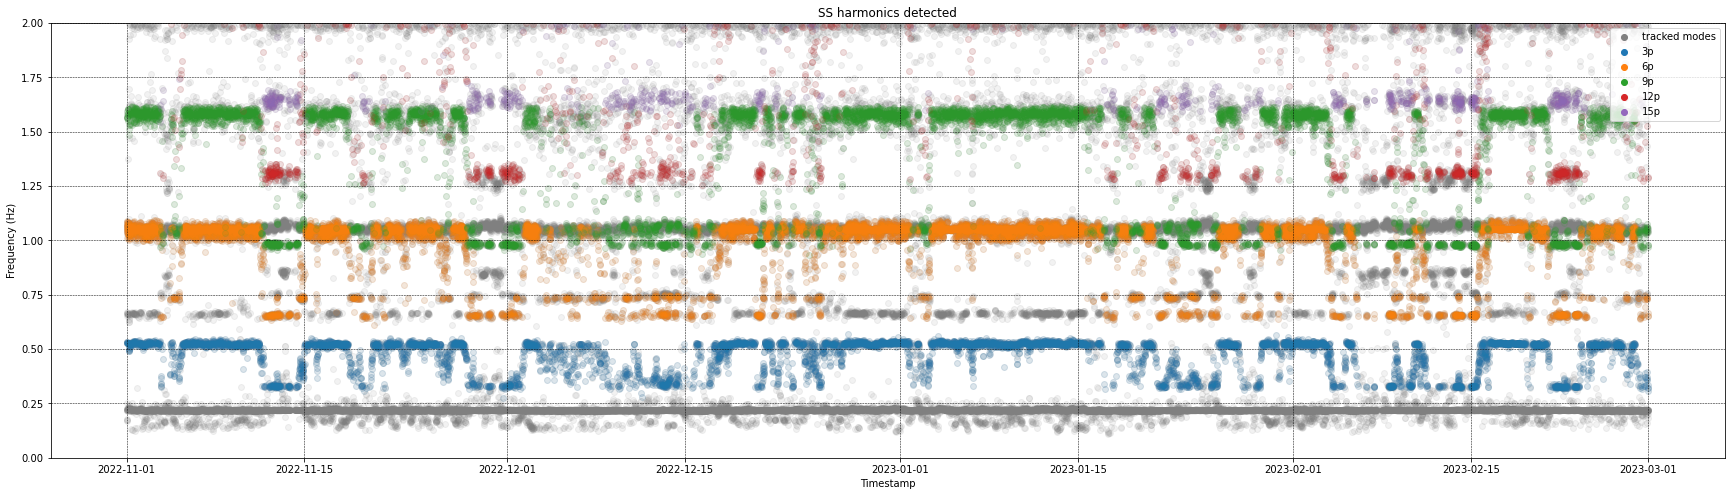

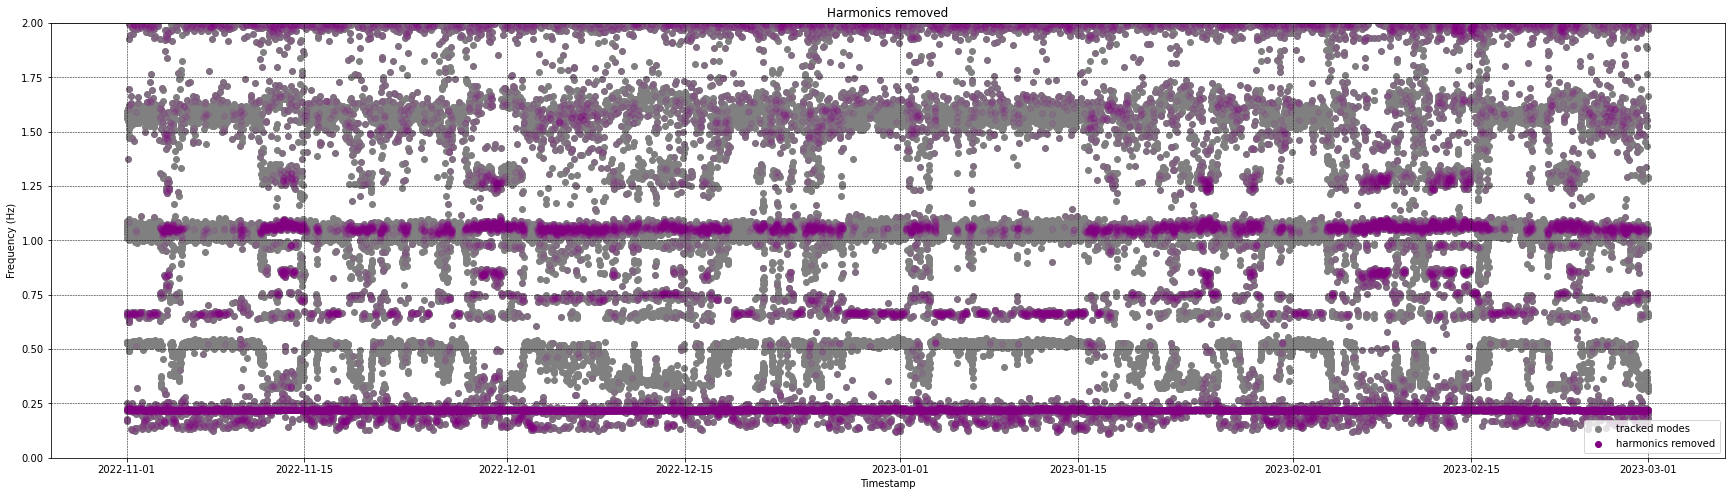

FA


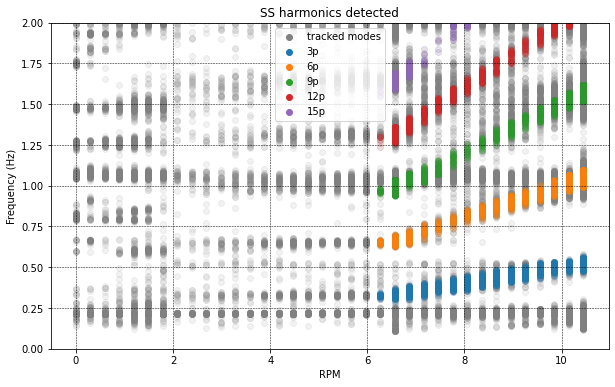

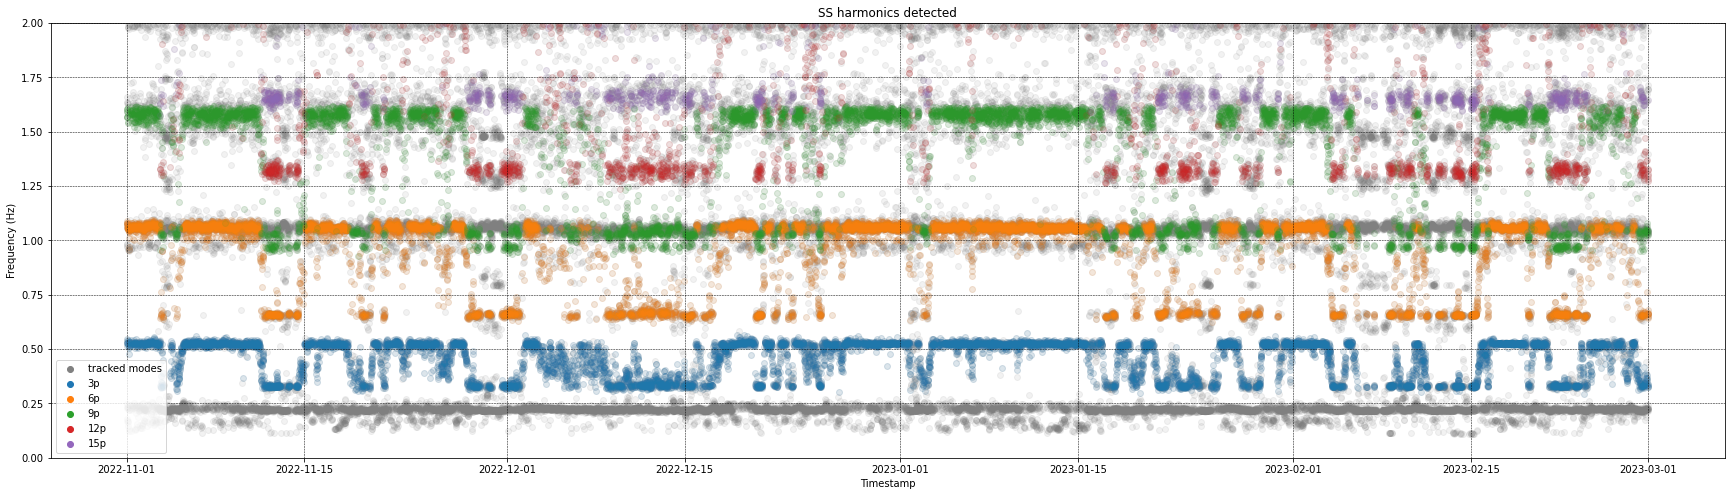

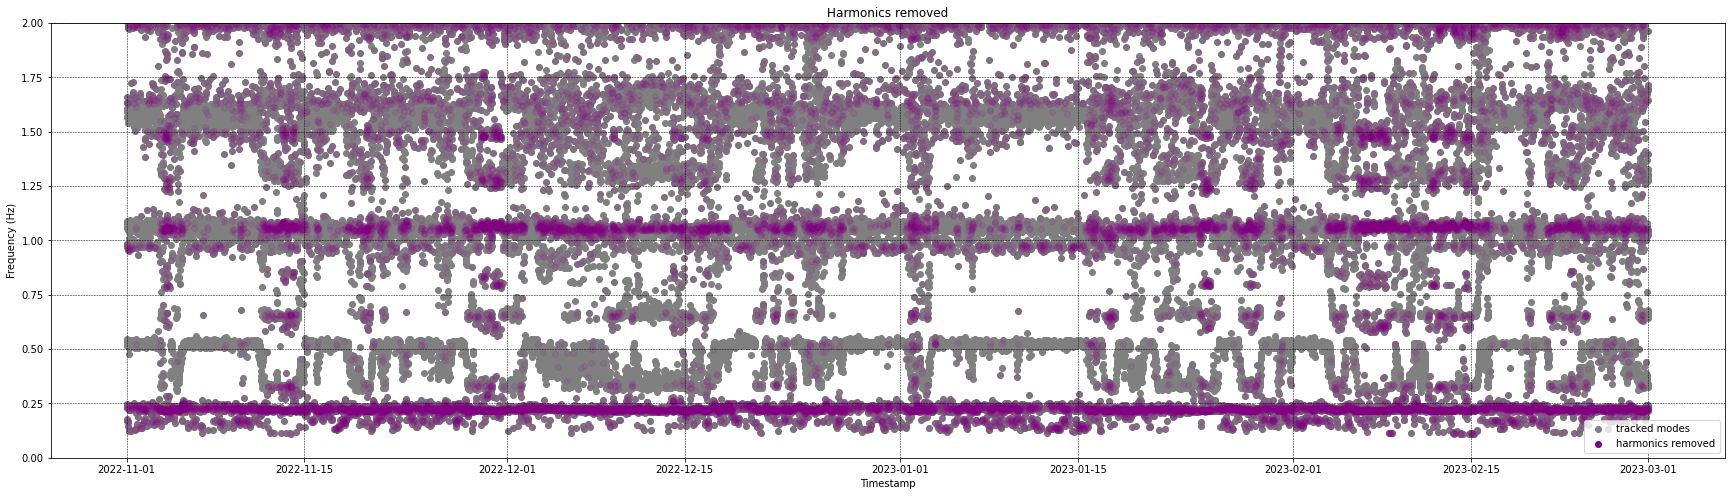

In [29]:
from oma_tracking.modal_tracking.harmonics import HarmonicDetector
harmonic_detectors = {}
harmonics_removed = {}
for direction in ['SS', 'FA']:
    print(direction)
    harmonic_detectors[direction] = HarmonicDetector(turbine_data, clustering_data[direction], p_orders=[3,6,9,12, 15])
    distance_calculator_data = harmonic_detectors[direction].get_distance_calculator_data()
    harmonic_detectors[direction].plot_distances()
    harmonic_detectors[direction].plot_harmonics_removed()
    harmonics_removed[direction] = harmonic_detectors[direction].remove_harmonics()


In [30]:
mpe_data['SS']

algorithm  mean_damping  mean_frequency  size  \
timestamp                                                                 
2022-11-01 00:00:00+00:00      lscf      4.806132        0.220005    30   
2022-11-01 00:00:00+00:00      lscf      3.664014        0.534838    25   
2022-11-01 00:00:00+00:00      lscf      0.521448        1.051824    39   
2022-11-01 00:00:00+00:00      lscf      2.455740        1.086731    31   
2022-11-01 00:00:00+00:00      lscf      2.565565        1.560832    35   
...                             ...           ...             ...   ...   
2023-03-01 00:00:00+00:00      lscf      1.110968        3.526182    34   
2023-03-01 00:00:00+00:00      lscf      0.176549        4.099797    17   
2023-03-01 00:00:00+00:00      lscf      0.523892        4.318310    41   
2023-03-01 00:00:00+00:00      lscf      0.241289        4.778458    18   
2023-03-01 00:00:00+00:00      lscf      2.207121        4.863657    41   

                           std_damping  std_frequency  
timestamp                                              
2022-11-01 00:00:00+00:00     0.285902       0.002627  
2022-11-01 00:00:00+00:00     0.498005       0.002628  
2022-11-01 00:00:00+00:00     0.156326       0.002546  
2022-11-01 00:00:00+00:00     0.158191       0.001997  
2022-11-01 00:00:00+00:00     0.247927       0.003127  
...                                ...            ...  
2023-03-01 00:00:00+00:00     0.259342       0.004861  
2023-03-01 00:00:00+00:00     0.066314       0.002645  
2023-03-01 00:00:00+00:00     0.042387       0.001671  
2023-03-01 00:00:00+00:00     0.127512       0.004538  
2023-03-01 00:00:00+00:00     0.056897       0.005494  

[186260 rows x 6 columns]

In [31]:
harmonics_removed['SS']

algorithm   damping  frequency  size  std_damping  \
timestamp                                                                     
2022-11-01 00:00:00+00:00      lscf  4.806132   0.220005    30     0.285902   
2022-11-01 00:10:00+00:00      lscf  3.460272   0.221963    37     0.273066   
2022-11-01 00:10:00+00:00      lscf  0.980789   0.660464    29     0.420751   
2022-11-01 00:20:00+00:00      lscf  2.032099   0.222790    41     0.379915   
2022-11-01 00:20:00+00:00      lscf  2.301205   0.653708    20     0.289153   
...                             ...       ...        ...   ...          ...   
2023-02-28 23:40:00+00:00      lscf  1.691806   0.219310    41     0.051393   
2023-02-28 23:50:00+00:00      lscf  1.748773   0.218162    41     0.031626   
2023-02-28 23:50:00+00:00      lscf  0.285400   1.045595    20     0.234319   
2023-03-01 00:00:00+00:00      lscf  2.514002   0.180771    15     0.294580   
2023-03-01 00:00:00+00:00      lscf  1.427276   0.218791    41     0.053208   

                           std_frequency  distance_3p  distance_6p  \
timestamp                                                            
2022-11-01 00:00:00+00:00       0.002627     0.302245     0.824495   
2022-11-01 00:10:00+00:00       0.002213     0.300287     0.822537   
2022-11-01 00:10:00+00:00       0.003035     0.138214     0.384036   
2022-11-01 00:20:00+00:00       0.000550     0.299460     0.821710   
2022-11-01 00:20:00+00:00       0.002135     0.131458     0.390792   
...                                  ...          ...          ...   
2023-02-28 23:40:00+00:00       0.000068     0.108940     0.437190   
2023-02-28 23:50:00+00:00       0.000123     0.110088     0.438338   
2023-02-28 23:50:00+00:00       0.004602     0.717345     0.389095   
2023-03-01 00:00:00+00:00       0.001079     0.147479     0.475729   
2023-03-01 00:00:00+00:00       0.000078     0.109459     0.437709   

                           distance_9p  distance_12p  distance_15p  \
timestamp                                                            
2022-11-01 00:00:00+00:00     1.346745      1.868995      2.391245   
2022-11-01 00:10:00+00:00     1.344787      1.867037      2.389287   
2022-11-01 00:10:00+00:00     0.906286      1.428536      1.950786   
2022-11-01 00:20:00+00:00     1.343960      1.866210      2.388460   
2022-11-01 00:20:00+00:00     0.913042      1.435292      1.957542   
...                                ...           ...           ...   
2023-02-28 23:40:00+00:00     0.765440      1.093690      1.421940   
2023-02-28 23:50:00+00:00     0.766588      1.094838      1.423088   
2023-02-28 23:50:00+00:00     0.060845      0.267405      0.595655   
2023-03-01 00:00:00+00:00     0.803979      1.132229      1.460479   
2023-03-01 00:00:00+00:00     0.765959      1.094209      1.422459   

                           mean_NW2_D01_rpm  
timestamp                                    
2022-11-01 00:00:00+00:00            10.445  
2022-11-01 00:10:00+00:00            10.445  
2022-11-01 00:10:00+00:00            10.445  
2022-11-01 00:20:00+00:00            10.445  
2022-11-01 00:20:00+00:00            10.445  
...                                     ...  
2023-02-28 23:40:00+00:00             6.565  
2023-02-28 23:50:00+00:00             6.565  
2023-02-28 23:50:00+00:00             6.565  
2023-03-01 00:00:00+00:00             6.565  
2023-03-01 00:00:00+00:00             6.565  

[36523 rows x 12 columns]

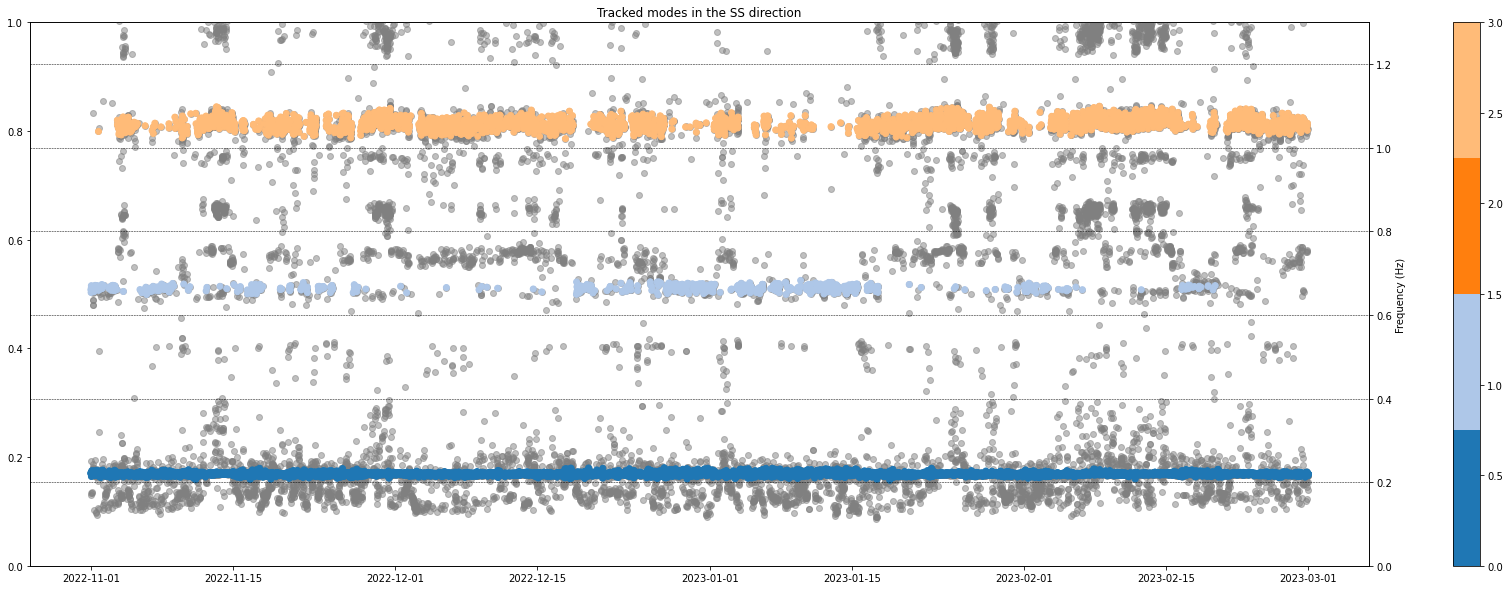

In [42]:
direction = 'SS'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = harmonics_removed[direction]
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)

plt.show()

SS1_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 0]
SS1_harmonics_removed = SS1_harmonics_removed[~SS1_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
SS2_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 3]
SS2_harmonics_removed = SS2_harmonics_removed[~SS2_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

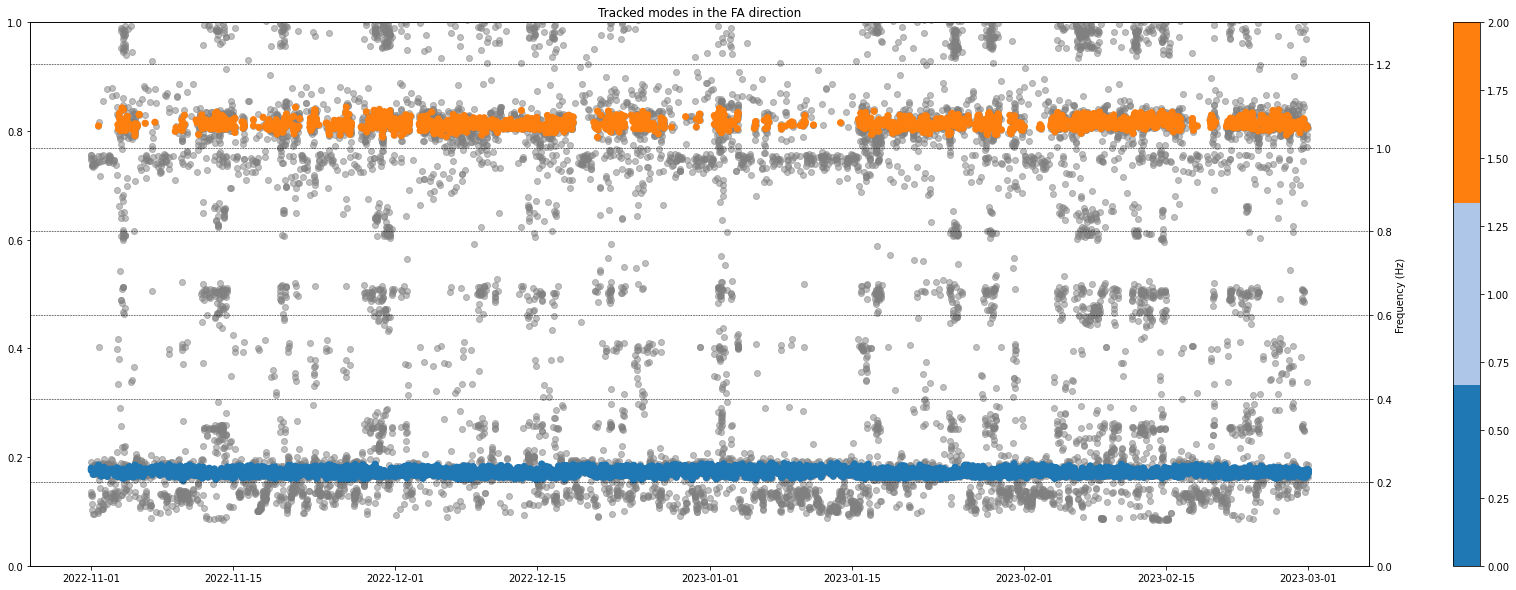

In [54]:
direction = 'FA'
mc[direction] = ModeClusterer(
    eps = 4,
    min_samples = 20,
    multipliers = {"frequency": 500, "size": 2, "damping": 5},
    index_divider = 2000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

clustering_data[direction] = harmonics_removed[direction]
mc[direction].fit(clustering_data[direction])
clustered_modes[direction] = mc[direction].predict(min_cluster_size=1000)

fig, ax2 = plt.subplots(figsize = (30,10))
#ax2.plot(turbine_data.filter(like='rpm').index, turbine_data.filter(like='rpm').values, color='k', alpha=1, label='RPM')
ax1 = ax2.twinx()
ax1.scatter(clustering_data[direction].index, clustering_data[direction]['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes[direction].labels.unique()),1))
cmap = ListedColormap(first_colors)

im = ax1.scatter(clustered_modes[direction].index, clustered_modes[direction]['frequency'], c=clustered_modes[direction]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(im, ax=ax1)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the ' + direction + ' direction')
plt.ylim(0, 1.3)

plt.show()

FA1_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 0]
FA1_harmonics_removed = FA1_harmonics_removed[~FA1_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)
FA2_harmonics_removed = clustered_modes[direction][clustered_modes[direction].labels == 2]
FA2_harmonics_removed = FA2_harmonics_removed[~FA2_harmonics_removed.index.duplicated()].reindex(clustering_data[direction][~clustering_data[direction].index.duplicated()].index)

In [58]:
FA2_harmonics_removed.dropna()

frequency  size   damping  labels
timestamp                                                   
2022-11-01 17:50:00+00:00   1.052251  38.0  2.459694     2.0
2022-11-03 15:30:00+00:00   1.054927  41.0  3.790812     2.0
2022-11-03 16:50:00+00:00   1.045372  41.0  3.247012     2.0
2022-11-03 18:20:00+00:00   1.044758  38.0  3.929481     2.0
2022-11-03 18:40:00+00:00   1.045575  39.0  2.490061     2.0
...                              ...   ...       ...     ...
2023-02-28 16:00:00+00:00   1.056847  38.0  3.016692     2.0
2023-02-28 17:00:00+00:00   1.052081  41.0  2.744453     2.0
2023-02-28 17:40:00+00:00   1.046380  41.0  1.853610     2.0
2023-02-28 19:40:00+00:00   1.051793  41.0  2.885659     2.0
2023-02-28 21:20:00+00:00   1.048701  38.0  2.902762     2.0

[2633 rows x 4 columns]

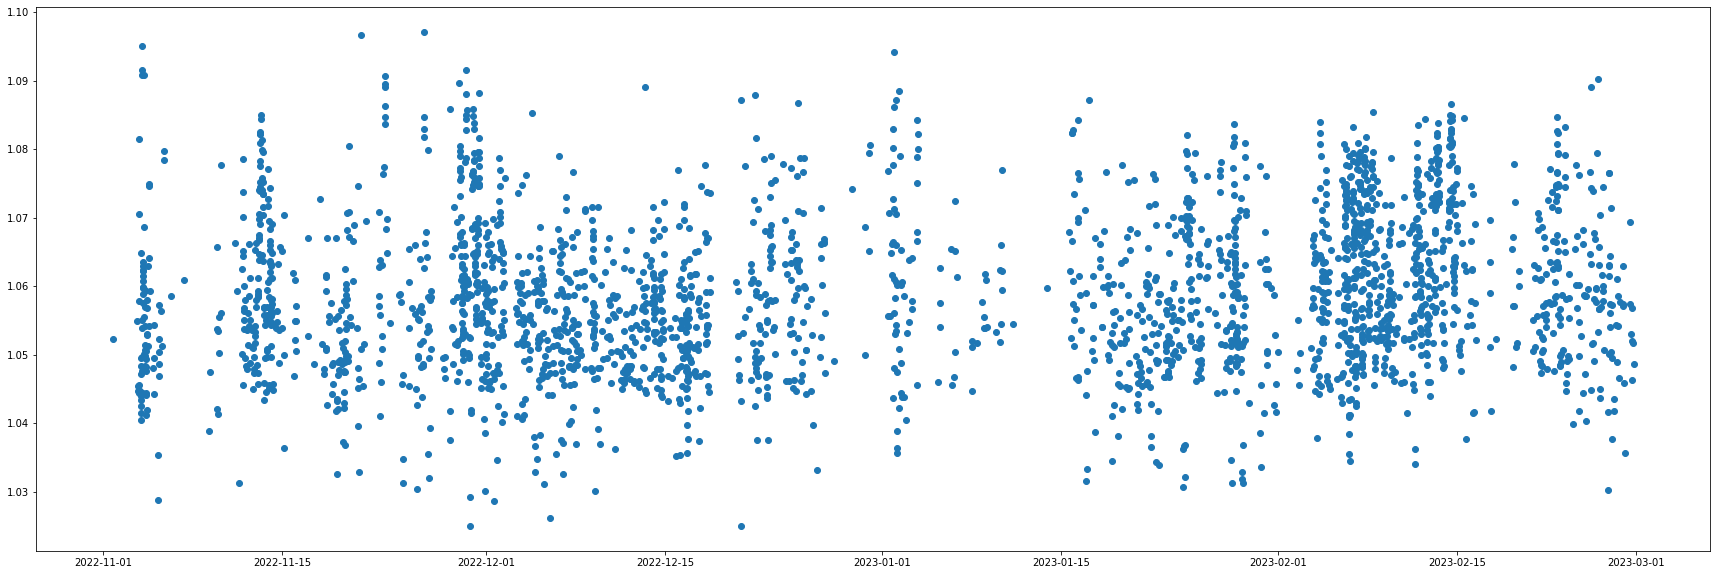

In [59]:
plt.figure(figsize=(30,10))
plt.scatter(FA2_harmonics_removed.index, FA2_harmonics_removed['frequency'], label='FA1')

In [57]:
tracked_frequencies_hamonics_removed = \
    pd.DataFrame(
        {
            'SS1': SS1_harmonics_removed['frequency'],
            'SS2': SS2_harmonics_removed['frequency'],
            'FA1': FA1_harmonics_removed['frequency'],
            'FA2': FA2_harmonics_removed['frequency'],
        }
    )

tracked_frequencies_hamonics_removed.to_parquet('../../data/nw2/tracked_modes/harmonics_removed/' + location + '.parquet', compression='gzip')